In [1]:
# Packages 
using Plots
gr()
using NCDatasets
using CSV
using DataFrames
using Dierckx
include("/Users/natenowel/Desktop/Github/ocean_julia/C2PO.jl")
using .C2PO
using Dates
using JLD2
using GibbsSeaWater
using PyCall
using LinearAlgebra

In [2]:
# Load in Glider Data
fl_glider_data_path = "/Users/natenowel/Desktop/SEA064_M48.csv"
electa_glider_data_path = "/Users/natenowel/Desktop/electa_norse23_sci_data.csv"

fl_data = CSV.read(fl_glider_data_path, DataFrame)
# electa_data = CSV.read(electa_glider_data_path, DataFrame)

Row,time,temperature,salinity,latitude,pressure,longitude,profile_number,declination
,DateTime,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,2023-11-12T16:24:42.970,-2.5969,NaN,71.0071,NaN,-6.51115,1,-5.0
2,2023-11-12T16:25:12.989,-2.6117,NaN,71.0071,NaN,-6.51115,1,-5.0
3,2023-11-12T16:25:43.014,-2.6,NaN,71.007,NaN,-6.5116,1,-5.0
4,2023-11-12T16:26:12.704,-2.7179,NaN,71.0069,NaN,-6.51175,1,-5.0
5,2023-11-12T16:26:42.740,-2.7207,NaN,71.0068,NaN,-6.5119,1,-5.0
6,2023-11-12T16:27:12.697,-2.6843,NaN,71.0068,NaN,-6.51197,1,-5.0
7,2023-11-12T16:27:42.779,-2.7124,NaN,71.0067,NaN,-6.51215,1,-5.0
8,2023-11-12T16:28:12.736,-2.6597,NaN,71.0067,NaN,-6.51222,1,-5.0
9,2023-11-12T16:28:42.759,-2.6468,NaN,71.0066,NaN,-6.51225,1,-5.0


In [3]:
# Dataframe w/ just surface data for interpolation 
# initialize new dataset 
surface_fl_data = DataFrame(
    time = DateTime[],
    temperature = Float64[],
    salinity = Float64[],
    latitude = Float64[],
    pressure = Float64[],
    longitude = Float64[],
    profile_number = Int64[],
    declination = Float64[]
)

# do same for electa 

function extract_surface_profiles!(original_data, surface_data)
    surface_index = 1
    for row = 1:length(original_data.temperature)
        if original_data.profile_number[row] == surface_index
            if surface_index > 1
                append!(surface_data, original_data[row-1:row-1, :])
            end
            append!(surface_data, original_data[row:row, :])
            surface_index += 1
        end
        if row == length(original_data.temperature)
            append!(surface_data, original_data[row:row, :])
        end
    end
end

extract_surface_profiles!(fl_data, surface_fl_data)
# do same for electa 

In [ ]:
# Load in ERA5 Data
wind_file_path = "/Users/natenowel/Desktop/ERA5/2023/2023_10mwinds.nc"
hf_file_path = "/Users/natenowel/Desktop/ERA5/2023/2023_heatfluxes.nc"
fw_file_path = "/Users/natenowel/Desktop/ERA5/2023/2023_tot_precip_evap.nc"
rad_file_path = "/Users/natenowel/Desktop/ERA5/2023/2023_avg_net_rad.nc"

wind_ds = Dataset(wind_file_path, "r")
hf_ds = Dataset(hf_file_path, "r")
fw_ds = Dataset(fw_file_path, "r")
rad_ds = Dataset(rad_file_path, "r")

In [5]:
# Interpolate ERA5 flux and evaporation data onto glider location 

function interpGrid(original_ds, variable::String, new_long, new_lat)
    # new_lat and new_long do not need to be sorted increasingly
    # assume original dataset from ERA5 has latitude sorted decreasingly 
    # indicies [long, lat, time]

    # sort original ERA5 dataset by latitude 

    # sort_ind = sortperm(original_ds["latitude"]); # create corrected indicies
    # lat_sorted = original_ds["latitude"][sort_ind]; # sort latitude 
    # var_sorted = original_ds[variable][:, sort_ind, :]; # sort associated variable wrt sorted latitude

    lat_sorted = reverse(original_ds["latitude"])
    var_sorted = reverse(original_ds[variable], dims=1)

    # sort new lat and new long increasingly 
    new_lat_sorted = sort(new_lat)
    new_long_sorted = sort(new_long)

    interpolated_grid = zeros(length(new_long_sorted), length(new_lat_sorted), length(original_ds["valid_time"])); # intiaize 3d grid (long, lat, time)

    for t = 1:length(original_ds["valid_time"]) # loop across all times
        spl = Spline2D(original_ds["longitude"][:], lat_sorted, var_sorted[:, :, t], kx=1, ky=1); # telling which variable to linearly interpolate 
        interpolated_grid[:, :, t] = evalgrid(spl, new_long_sorted, new_lat_sorted); # interpolating onto new grid 
        # display(interpolated_grid[:, :, t])
    end
    return interpolated_grid
end

interpGrid (generic function with 1 method)

In [42]:
# Interpolated arrays 

# fl_interp_u10 = interpGrid(wind_ds, "u10", surface_fl_data.longitude, surface_fl_data.latitude);
# fl_interp_v10 = interpGrid(wind_ds, "v10", surface_fl_data.longitude, surface_fl_data.latitude);
# fl_interp_wind_speed = (fl_interp_u10.^2 + fl_interp_v10.^2).^(1/2);
# fl_interp_wind_stress = C2PO.stresslp(interp_wind_speed, 10)

# fluxes are positive downwards

fl_interp_sshf = interpGrid(hf_ds, "sshf", surface_fl_data.longitude, surface_fl_data.latitude) ./ 3600;
fl_interp_slhf = interpGrid(hf_ds, "slhf", surface_fl_data.longitude, surface_fl_data.latitude) ./ 3600;
fl_interp_net_lwrad = interpGrid(rad_ds, "avg_snlwrfcs", surface_fl_data.longitude, surface_fl_data.latitude) .* 1;
fl_interp_net_swrad = interpGrid(rad_ds, "avg_snswrfcs", surface_fl_data.longitude, surface_fl_data.latitude) .* 1;
fl_interp_net_tot_rad = fl_interp_net_lwrad + fl_interp_net_swrad;
fl_interp_tot_hf = fl_interp_net_tot_rad + fl_interp_slhf + fl_interp_sshf;

fl_interp_precip = interpGrid(fw_ds, "tp", surface_fl_data.longitude, surface_fl_data.latitude);
fl_interp_evap = interpGrid(fw_ds, "e", surface_fl_data.longitude, surface_fl_data.latitude);

# do same for electa 

496×496×720 Array{Float64, 3}:
[:, :, 1] =
 -4.69941e-5  -4.69941e-5  -4.70358e-5  …  -3.8099e-5   -3.8099e-5
 -4.69941e-5  -4.69941e-5  -4.70358e-5     -3.8099e-5   -3.8099e-5
 -4.69833e-5  -4.69833e-5  -4.70251e-5     -3.80978e-5  -3.80978e-5
 -4.69833e-5  -4.69833e-5  -4.70251e-5     -3.80978e-5  -3.80978e-5
 -4.69613e-5  -4.69613e-5  -4.70035e-5     -3.80953e-5  -3.80953e-5
 -4.69613e-5  -4.69613e-5  -4.70035e-5  …  -3.80953e-5  -3.80953e-5
 -4.69254e-5  -4.69254e-5  -4.69681e-5     -3.80913e-5  -3.80913e-5
 -4.69254e-5  -4.69254e-5  -4.69681e-5     -3.80913e-5  -3.80913e-5
 -4.68417e-5  -4.68417e-5  -4.68858e-5     -3.80819e-5  -3.80819e-5
 -4.68417e-5  -4.68417e-5  -4.68858e-5     -3.80819e-5  -3.80819e-5
  ⋮                                     ⋱                ⋮
 -2.768e-5    -2.768e-5    -2.78841e-5     -4.11559e-5  -4.11559e-5
 -2.73347e-5  -2.73347e-5  -2.75401e-5     -4.1182e-5   -4.1182e-5
 -2.73347e-5  -2.73347e-5  -2.75401e-5     -4.1182e-5   -4.1182e-5
 -2.69947e-5  -2.6

In [51]:
t1 = DateTime("2023-11-13T00:00:00")
t2 = DateTime("2023-11-27T00:00:00")
hf_mask = findall((hf_ds["valid_time"] .>= t1) .& (hf_ds["valid_time"] .<= t2))
tot_hf_plot = plot(hf_ds["valid_time"][hf_mask], -fl_interp_tot_hf[313, 425, hf_mask], 
    title="Total Heat Flux, November 2023", ylabel="Heat Flux (W/m^2)", xlabel="Time (date)")
savefig(tot_hf_plot, "/Users/natenowel/Desktop/tot_hf_plot.png")

"/Users/natenowel/Desktop/tot_hf_plot.png"

In [12]:
# High flux
t1 = DateTime("2023-11-23T00:00:00")
t2 = DateTime("2023-11-24T00:00:00")
# sort_long = sort(surface_fl_data.longitude)
# sort_lat = sort(surface_fl_data.latitude)
# flux_profile_num = 186 
# long_idx = findfirst(==(surface_fl_data.longitude[2*flux_profile_num-1]), sort_long) # 313
# lat_idx = findfirst(==(surface_fl_data.latitude[2*flux_profile_num-1]), sort_lat) # 425
mask = findall((hf_ds["valid_time"] .>= t1) .& (hf_ds["valid_time"] .<= t2))
hf_plot = plot(-fl_interp_tot_hf[313, 425, mask], title="Atmospheric Heat Flux 11/23", ylabel="Total Heat Flux (W/m^2)", xlabel="Time (hours)")
savefig(hf_plot, "/Users/natenowel/Desktop/hf_plot.png")

"/Users/natenowel/Desktop/hf_plot.png"

In [13]:
# Low flux 
t1 = DateTime("2023-11-21T06:00:00")
t2 = DateTime("2023-11-22T06:00:00")
# sort_long = sort(surface_fl_data.longitude)
# sort_lat = sort(surface_fl_data.latitude)
# flux_profile_num = 150 
# long_idx = findfirst(==(surface_fl_data.longitude[2*flux_profile_num-1]), sort_long) # 191
# lat_idx = findfirst(==(surface_fl_data.latitude[2*flux_profile_num-1]), sort_lat) # 423
masklow = findall((hf_ds["valid_time"] .>= t1) .& (hf_ds["valid_time"] .<= t2))
lf_plot = plot(-fl_interp_tot_hf[191, 423, masklow], title="Atmospheric Heat Flux 11/21", ylabel="Total Heat Flux (W/m^2)", xlabel="Time (hours)")
savefig(lf_plot, "/Users/natenowel/Desktop/lf_plot.png")

"/Users/natenowel/Desktop/lf_plot.png"

In [59]:
# calcualte mixed layer depth

using DelimitedFiles
using SeawaterPolynomials
using DSP
#filtered_df = filter(row -> time1 <= row.TimeStamp <= time2, subset_binned);
#subset1[:, "time"] = subset1.time .* 10^-9
#subset_filt = filter(row -> row.depth .>= 0, subset1)


# Calculate density
# pressure = depth * 0.1  # Convert depth to pressure (approximate)
# Define the density criterion for the MLD  # Surface density + 0.03 kg/m³
eos = SeawaterPolynomials.TEOS10EquationOfState()
# Find the mixed layer depth
function find_mld(df::DataFrame, density_criterion::Float64, profiles::String, temp::String, salt::String, depth::String, time::String)
    # Inputs:
    # df is the DataFrame containing the CTD data
    # density_criterion is the threshold for the density difference
    # profiles is the column name for grouping the data
    # temp is the column name for temperature
    # salt is the column name for salinity
    # depth is the column name for depth
    # time is the column name for time
    # Outputs:
    # mld_df is a DataFrame containing the mixed layer depth for each profile
    # this DataFrame has columns: diveNum, density_mld, time
    # Initialize an empty DataFrame to store the mixed layer depth results
    global mld_df
    # Group the DataFrame by the specified profiles
    gdf = groupby(df, profiles)
    dives = length(unique(gdf))
    # Creating a low pass filter to only low frequency signals from the CTD data
    # Define the sampling frequency and cutoff frequency for the low-pass filter
    fs = 1.0    # Sampling frequency in Hz
    fc = 0.1    # Cutoff frequency in Hz
    # Normalize the cutoff frequency
    fnorm = fc / (fs / 2)
    # Design the Butterworth filter
    filter_order = 4  # Choose the order of the filter
    lp_filter = digitalfilter(DSP.Filters.Lowpass(fnorm), Butterworth(filter_order))
    mld_df_list = []
    # Loop through each dive in the grouped DataFrame
    # and calculate the mixed layer depth
    for ii in 1:dives
        yo = gdf[ii]
        time_col = yo[!, time]
        depth_col = yo[!, depth]  # Depth column
        temperature_col = yo[!, temp]  # Temperature column
        salinity_col = yo[!, salt]
        salinity = filtfilt(lp_filter, salinity_col)
        temperature = filtfilt(lp_filter, temperature_col)
        density = gsw_rho.(temperature, salinity, depth_col)
        density_diff = diff(density)
        density_ind = findfirst(x -> x > density_criterion, density_diff)
        if density_ind == nothing
            density_mld = missing
            new_time = missing
        else
            density_mld = depth_col[density_ind]
            new_time = time_col[density_ind]
        end
        loop_df = DataFrame(diveNum=ii, density_mld=density_mld, time=new_time)
        df_tot = push!(mld_df_list, loop_df)
        mld_df = vcat(df_tot...)
    end
    return mld_df
end


find_mld (generic function with 1 method)

In [14]:
# First filter out the NaNs 
fldata_valid_indexes = .!(isnan.(fl_data.pressure)) 
fl_temp = fl_data.temperature[fldata_valid_indexes]
fl_salinity = fl_data.salinity[fldata_valid_indexes]
fl_pressure = fl_data.pressure[fldata_valid_indexes]
fl_longitude = fl_data.longitude[fldata_valid_indexes]
fl_latitude = fl_data.latitude[fldata_valid_indexes]
fl_profiles = fl_data.profile_number[fldata_valid_indexes]
fl_time = fl_data.time[fldata_valid_indexes]

fl_sa = gsw_sa_from_sp.(fl_salinity, fl_pressure, fl_longitude, fl_latitude) # calculate absolute salinity
fl_ct = gsw_ct_from_t.(fl_sa, fl_temp, fl_pressure) # calculate conservative temperature 

# Create new dataframe 
fl_df = DataFrame(time = fl_time, 
                  temperature = fl_temp,
                  salinity = fl_salinity, 
                  latitude = fl_latitude,
                  pressure = fl_pressure,
                  longitude = fl_salinity,
                  profile_number = fl_profiles, 
                  conservative_temperature = fl_ct, 
                  absolute_salinity = fl_sa,
                  )

# do same for electa 

Row,time,temperature,salinity,latitude,pressure,longitude,profile_number,conservative_temperature,absolute_salinity
,DateTime,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,2023-11-12T17:51:46.056,1.093,34.3002,70.9617,0.9739,34.3002,1,1.09564,34.4632
2,2023-11-12T17:52:16.115,1.0762,34.2997,70.9616,0.7784,34.2997,1,1.07886,34.4627
3,2023-11-12T17:52:46.088,1.0795,34.3268,70.9614,0.9605,34.3268,1,1.08199,34.4899
4,2023-11-12T17:53:16.121,1.0879,34.3249,70.9613,1.3869,34.3249,1,1.09038,34.488
5,2023-11-12T17:53:46.230,1.0727,34.3898,70.9613,0.8635,34.3898,1,1.07483,34.5532
6,2023-11-12T17:54:16.217,1.0795,34.4043,70.9612,1.8988,34.4043,1,1.08149,34.5678
7,2023-11-12T17:54:46.200,1.063,34.3961,70.9612,1.3712,34.3961,1,1.06507,34.5596
8,2023-11-12T17:55:16.209,1.0776,34.3818,70.9611,1.2705,34.3818,1,1.07975,34.5452
9,2023-11-12T17:55:46.204,1.1072,34.3993,70.961,1.5063,34.3993,1,1.10923,34.5628


In [ ]:
# Glider MLDs
fl_mld = find_mld(fl_df, 0.04, "profile_number", "conservative_temperature", "absolute_salinity", "pressure", "time")

# do same for electa 

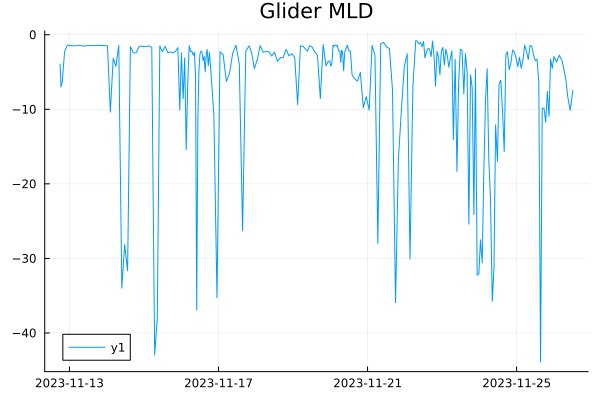

In [65]:
plot(fl_mld.time, -fl_mld.density_mld, title="Glider MLD")

In [18]:
# Create subset of glider times of interest here before interpolating 
start_time_index = 24859 - 177 # 29866 (high flux) 24859 (low flux)
end_time_index = start_time_index + 2895 - 2 # +6 (high flux) -2 (low flux) # amount of timesteps in one day on FL

fl_df_subset = fl_df[start_time_index:end_time_index, :]
# electa_df_subset = electa_df[start_time_index:end_time_index]

# now interpolate onto these times 

Row,time,temperature,salinity,latitude,pressure,longitude,profile_number,conservative_temperature,absolute_salinity
,DateTime,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,2023-11-21T06:29:31.288,0.159,33.7257,71.2947,2.5257,33.7257,143,0.16442,33.886
2,2023-11-21T06:30:01.305,0.1633,33.7257,71.2947,0.8391,33.7257,143,0.16878,33.886
3,2023-11-21T06:31:00.245,0.1652,33.7268,71.2947,1.104,33.7268,143,0.170667,33.8871
4,2023-11-21T06:31:04,0.1635,33.7248,71.2948,1.121,33.7248,143,0.168974,33.8851
5,2023-11-21T06:31:30.189,0.1619,33.7251,71.2948,0.9947,33.7251,144,0.167377,33.8854
6,2023-11-21T06:31:57.305,0.1627,33.7263,71.2949,1.1806,33.7263,144,0.168165,33.8866
7,2023-11-21T06:32:27.332,0.1635,33.7242,71.2949,1.2077,33.7242,144,0.168974,33.8845
8,2023-11-21T06:32:57.350,0.163,33.7233,71.295,1.18,33.7233,144,0.168479,33.8836
9,2023-11-21T06:33:27.348,0.1615,33.7218,71.295,1.1273,33.7218,144,0.166986,33.8821


In [19]:
# fl_df_high_flux = fl_df_subset 
fl_df_low_flux = fl_df_subset 

Row,time,temperature,salinity,latitude,pressure,longitude,profile_number,conservative_temperature,absolute_salinity
,DateTime,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,2023-11-21T06:29:31.288,0.159,33.7257,71.2947,2.5257,33.7257,143,0.16442,33.886
2,2023-11-21T06:30:01.305,0.1633,33.7257,71.2947,0.8391,33.7257,143,0.16878,33.886
3,2023-11-21T06:31:00.245,0.1652,33.7268,71.2947,1.104,33.7268,143,0.170667,33.8871
4,2023-11-21T06:31:04,0.1635,33.7248,71.2948,1.121,33.7248,143,0.168974,33.8851
5,2023-11-21T06:31:30.189,0.1619,33.7251,71.2948,0.9947,33.7251,144,0.167377,33.8854
6,2023-11-21T06:31:57.305,0.1627,33.7263,71.2949,1.1806,33.7263,144,0.168165,33.8866
7,2023-11-21T06:32:27.332,0.1635,33.7242,71.2949,1.2077,33.7242,144,0.168974,33.8845
8,2023-11-21T06:32:57.350,0.163,33.7233,71.295,1.18,33.7233,144,0.168479,33.8836
9,2023-11-21T06:33:27.348,0.1615,33.7218,71.295,1.1273,33.7218,144,0.166986,33.8821


In [92]:
# function to temporally interpolate ERA5 heat flux data onto glider times (fl_df)
using Interpolations

# Dimensions
Nlons, Nlats, Ntimes = length(surface_fl_data.longitude), length(surface_fl_data.latitude), length(fl_df_subset.time)

# Create array
# fl_F_0 = Array{Float64}(undef, Nlons, Nlats, Ntimes)
# fl_E_0 = Array{Float64}(undef, Nlons, Nlats, Ntimes)
fl_P_0 = Array{Float64}(undef, Nlons, Nlats, Ntimes)

era5_times_unix = datetime2unix.(hf_ds["valid_time"][:])  # Float64[]
fl_times_unix = datetime2unix.(fl_df_subset.time)         # Float64[]


# Loop through each grid point and interpolate over time
for i in 1:Nlons, j in 1:Nlats
    # Extract time series at (lon_i, lat_j)
    # q_era5 = fl_interp_tot_hf[i, j, :]
    # q_era5 = fl_interp_evap[i, j, :]
    q_era5 = fl_interp_precip[i, j, :]

    # Create interpolant 
    itp = LinearInterpolation(era5_times_unix, q_era5, extrapolation_bc=Flat())

    # Interpolate onto glider times 
    # fl_F_0[i, j, :] = itp.(fl_times_unix)
    # fl_E_0[i, j, :] = itp.(fl_times_unix)
    fl_P_0[i, j, :] = itp.(fl_times_unix)
end

# fl_F_0
# fl_E_0
fl_P_0

# do same for electa 

496×496×2894 Array{Float64, 3}:
[:, :, 1] =
 0.000157149  0.000157149  0.000157694  …  0.000135683  0.000135683
 0.000157149  0.000157149  0.000157694     0.000135683  0.000135683
 0.000157264  0.000157264  0.000157809     0.00013575   0.00013575
 0.000157264  0.000157264  0.000157809     0.00013575   0.00013575
 0.000157497  0.000157497  0.000158043     0.000135886  0.000135886
 0.000157497  0.000157497  0.000158043  …  0.000135886  0.000135886
 0.000157877  0.000157877  0.000158425     0.000136109  0.000136109
 0.000157877  0.000157877  0.000158425     0.000136109  0.000136109
 0.000158763  0.000158763  0.000159315     0.000136629  0.000136629
 0.000158763  0.000158763  0.000159315     0.000136629  0.000136629
 ⋮                                      ⋱               ⋮
 0.000479476  0.000479476  0.000480294     0.000371868  0.000371868
 0.000481665  0.000481665  0.00048248      0.000374004  0.000374004
 0.000481665  0.000481665  0.00048248      0.000374004  0.000374004
 0.000484668  0.

In [205]:
# change back and forth between high and low flux data

# fl_df_subset = fl_df_high_flux
# fl_F_0 = fl_F_0_high_flux
# fl_E_0 = fl_E_0_high_flux
# fl_P_0 = fl_P_0_high_flux
# fl_mld_interp = fl_mld_interp_high_flux
# fl_delta_t = fl_delta_t_high_flux
# fl_delta_s = fl_delta_s_high_flux
# fl_initial_profile = fl_initial_profile_high_flux
# fl_T_0 = fl_T_0_high_flux
# fl_S_0 = fl_S_0_high_flux
# fl_ρ_0 = fl_ρ_0_high_flux
# fl_ρ_interp = fl_ρ_interp_high_flux
# fl_T_interp = fl_T_interp_high_flux
# fl_S_interp = fl_S_interp_high_flux
# T = fl_T_0_high_flux
# S = fl_S_0_high_flux

fl_df_subset = fl_df_low_flux
fl_F_0 = fl_F_0_low_flux
fl_E_0 = fl_E_0_low_flux
fl_P_0 = fl_P_0_low_flux
fl_mld_interp = fl_mld_interp_low_flux
fl_delta_t = fl_delta_t_low_flux
fl_delta_s = fl_delta_s_low_flux
fl_initial_profile = fl_initial_profile_low_flux
fl_T_0 = fl_T_0_low_flux
fl_S_0 = fl_S_0_low_flux
fl_ρ_0 = fl_ρ_0_low_flux
fl_ρ_interp = fl_ρ_interp_low_flux
fl_T_interp = fl_T_interp_low_flux
fl_S_interp = fl_S_interp_low_flux
T = fl_T_0_low_flux
S = fl_S_0_low_flux

227-element Vector{Float64}:
 33.9411
 33.9339
 33.9345
 33.9344
 33.9353
 33.9266
 33.9355
 33.9295
 33.9299
 33.9283
  ⋮
 34.3718
 34.2437
 34.0985
 33.7933
 33.7711
 33.7605
 33.7579
 33.7575
 33.7616

In [121]:
# variables to store high flux data so you dont have to reinterpolate 
fl_df_high_flux = fl_df_subset
fl_F_0_high_flux = fl_F_0
fl_E_0_high_flux = fl_E_0
fl_P_0_high_flux = fl_P_0
fl_mld_interp_high_flux = fl_mld_interp
fl_delta_t_high_flux = fl_delta_t
fl_delta_s_high_flux = fl_delta_s
fl_initial_profile_high_flux = fl_initial_profile
fl_T_0_high_flux = fl_T_0
fl_S_0_high_flux = fl_S_0
fl_ρ_0_high_flux = fl_ρ_0
fl_ρ_interp_high_flux = fl_ρ_interp
fl_T_interp_high_flux = fl_T_interp
fl_S_interp_high_flux = fl_S_interp
fl_T_high_flux = T
fl_S_high_flux = S

601×2902 Matrix{Float64}:
 33.5489  33.5488  33.5486  33.5485  …  33.3951  33.3951  33.395   33.395
 33.5419  33.5418  33.5417  33.5415     33.3881  33.3881  33.3881  33.388
 33.5651  33.5651  33.5651  33.5651     33.4277  33.4277  33.4276  33.4276
 33.5422  33.5422  33.5422  33.5422     33.45    33.45    33.45    33.45
 33.552   33.552   33.552   33.552      33.4878  33.4878  33.4877  33.4877
 33.5617  33.5617  33.5617  33.5617  …  33.5066  33.5066  33.5066  33.5065
 33.5571  33.5571  33.5571  33.5571     33.5098  33.5098  33.5097  33.5097
 33.5486  33.5486  33.5486  33.5486     33.5023  33.5022  33.5022  33.5022
 33.5414  33.5414  33.5414  33.5414     33.5101  33.51    33.51    33.51
 33.5474  33.5474  33.5474  33.5474     33.5176  33.5176  33.5176  33.5176
  ⋮                                  ⋱                     ⋮       
 34.9335  34.9335  34.9335  34.9335     34.9335  34.9335  34.9335  34.9335
 34.9335  34.9335  34.9335  34.9335     34.9335  34.9335  34.9335  34.9335
 34.9335  34

In [125]:
# variables to store low flux data so you dont have to reinterpolate 
fl_df_low_flux = fl_df_subset
fl_F_0_low_flux = fl_F_0
fl_E_0_low_flux = fl_E_0
fl_P_0_low_flux = fl_P_0
fl_mld_interp_low_flux = fl_mld_interp
fl_delta_t_low_flux = fl_delta_t
fl_delta_s_low_flux = fl_delta_s
fl_initial_profile_low_flux = fl_initial_profile
fl_T_0_low_flux = fl_T_0
fl_S_0_low_flux = fl_S_0
fl_ρ_0_low_flux = fl_ρ_0
fl_ρ_interp_low_flux = fl_ρ_interp
fl_T_interp_low_flux = fl_T_interp
fl_S_interp_low_flux = fl_S_interp
fl_T_low_flux = T
fl_S_low_flux = S

601×2894 Matrix{Float64}:
 33.7575  33.7575  33.7575  33.7575  …  33.6262  33.6261  33.6242  33.6242
 33.8549  33.8549  33.8549  33.8549     33.7236  33.7235  33.7216  33.7216
 33.9275  33.9275  33.9275  33.9275     33.8973  33.8972  33.8954  33.8953
 33.7936  33.7936  33.7936  33.7936     33.7624  33.7624  33.7624  33.7624
 33.7745  33.7745  33.7745  33.7745     33.7518  33.7518  33.7518  33.7518
 33.8386  33.8386  33.8386  33.8386  …  33.8241  33.8241  33.8241  33.8241
 33.9027  33.9027  33.9027  33.9027     33.9064  33.9064  33.9064  33.9064
 33.8689  33.8689  33.8689  33.8689     33.8814  33.8814  33.8814  33.8814
 33.7803  33.7803  33.7803  33.7803     33.7957  33.7957  33.7957  33.7957
 33.7758  33.7758  33.7758  33.7758     33.8007  33.8007  33.8007  33.8007
  ⋮                                  ⋱   ⋮                         
 34.9565  34.9565  34.9565  34.9565     34.9565  34.9565  34.9565  34.9565
 34.9566  34.9566  34.9566  34.9566     34.9566  34.9566  34.9566  34.9566
 34.95

In [93]:
# function to temporally interpolate mld data onto glider times (fl_mld)
fl_mld_times_unix = datetime2unix.(fl_mld.time) 

itp = LinearInterpolation(fl_mld_times_unix, fl_mld.density_mld, extrapolation_bc=Flat())
fl_mld_interp = itp.(fl_times_unix)

# do same for electa 

2894-element Vector{Float64}:
 26.20123004565376
 26.31399048588949
 26.53540169740064
 26.549507552967636
 26.647887909466117
 26.749750591323025
 26.86254859704926
 26.975312793565347
 27.088001859996055
 27.200758543951423
  ⋮
  2.8360032882648465
  2.8090100016118718
  2.7820131179386536
  2.755019831285679
  2.7280256452168423
  2.701015272449709
  2.674020187179411
  2.6470269005264373
  2.6200327146720017

In [141]:
t_hours = (datetime2unix.(fl_df_subset.time) .- datetime2unix(fl_df_subset.time[1])) ./ 3600  # in hours
p = plot(t_hours, -fl_mld_interp, title="Glider High Flux MLD", xlabel = "Time (hours)", ylabel = "Mixed Layer Depth (m)")
savefig(p, "/Users/NateNowel/Desktop/Plots/fl/MLD_plots/Glider_HF_MLD.png")

"/Users/NateNowel/Desktop/Plots/fl/MLD_plots/Glider_HF_MLD.png"

In [95]:
# function to find temperature grad across mld 
function get_temp_grad(interp_mld, orginal_ds)
    # should have the same time indicies 
    grad_vec = []
    for i = 1:length(interp_mld)# -1
        mld = interp_mld[i]
        idx = argmin(abs.(orginal_ds.pressure .- mld)) # argmin finds the smallest difference, gives index of mixed layer 
        grad = orginal_ds.temperature[idx+1] - orginal_ds.temperature[idx]
        append!(grad_vec, grad)
    end 
    # append!(grad_vec, grad)

    return grad_vec
end 

fl_delta_t = get_temp_grad(fl_mld_interp, fl_df)

# do same for electa 

2894-element Vector{Any}:
 -0.14149999999999974
  0.01540000000000008
  0.002200000000000202
 -0.009000000000000008
 -0.0045000000000001705
 -0.3447
  0.028400000000000425
  0.12419999999999998
 -0.2319
  0.025399999999999867
  ⋮
  0.023399999999999643
  0.36440000000000006
  0.006099999999999994
  0.0015000000000000013
 -0.0002999999999999947
 -0.017599999999999838
  0.01629999999999998
  0.9769000000000001
  0.0118999999999998

In [96]:
# function to find salinity grad across mld 
function get_salinity_grad(interp_mld, orginal_ds)
    # should have the same time indicies 
    s_grad_vec = []
    for i = 1:length(interp_mld)# -1
        mld = interp_mld[i]
        idx = argmin(abs.(orginal_ds.pressure .- mld)) # argmin finds the smallest difference, gives index of mixed layer 
        grad = orginal_ds.salinity[idx+1] - orginal_ds.salinity[idx]
        append!(s_grad_vec, grad)
    end 
    # append!(grad_vec, grad)

    return s_grad_vec
end 

fl_delta_s = get_salinity_grad(fl_mld_interp, fl_df)

# do same for electa 

2894-element Vector{Any}:
 -0.03170000000000073
  0.005200000000002092
  0.00039999999999906777
 -0.002200000000001978
 -0.005899999999996908
 -0.13700000000000045
  0.02169999999999561
  0.0502000000000038
 -0.216700000000003
 -0.0020999999999986585
  ⋮
  0.0009999999999976694
  0.06929999999999836
  0.001999999999995339
  0.0020999999999986585
  0.001799999999995805
  0.0005000000000023874
  0.006999999999997897
  0.1799000000000035
  0.004400000000003956

In [97]:
# start_time_index = 350 # in fl_df, should be start of a new profile, ex profile number 150 
# end_time_index = 400 

# function to extract temperature profile of certain profile number 
function get_initial_profile(original_ds, profile_num)
    initial_profile = DataFrame(
        time = DateTime[],
        temperature = Float64[],
        salinity = Float64[],
        latitude = Float64[],
        pressure = Float64[],
        longitude = Float64[],
        profile_number = Int64[],
        conservative_temperature = Float64[],
        absolute_salinity = Float64[],
        # declination = Float64[]
        )

    for row = 1:length(original_ds.temperature)
        if original_ds.profile_number[row] == profile_num
            append!(initial_profile, original_ds[row:row, :])
        end 
    end 
    return initial_profile
end 

profile_num = 142 # 174 (high flux) 142 (low flux)
fl_initial_profile = get_initial_profile(fl_df, profile_num)
fl_T_0 = fl_initial_profile.temperature
fl_S_0 = fl_initial_profile.salinity

# do same for electa 

227-element Vector{Float64}:
 33.9411
 33.9339
 33.9345
 33.9344
 33.9353
 33.9266
 33.9355
 33.9295
 33.9299
 33.9283
  ⋮
 34.3718
 34.2437
 34.0985
 33.7933
 33.7711
 33.7605
 33.7579
 33.7575
 33.7616

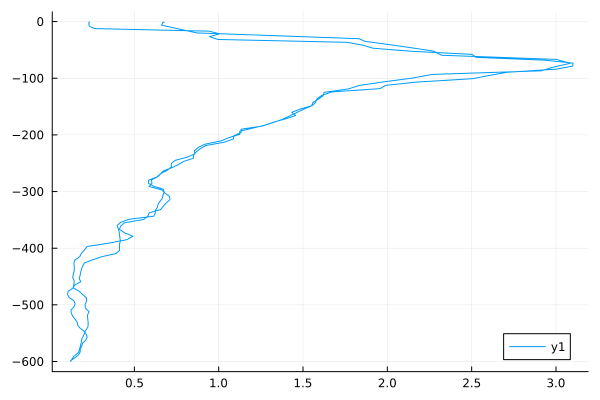

In [98]:
plot(fl_initial_profile.temperature, -fl_initial_profile.pressure)

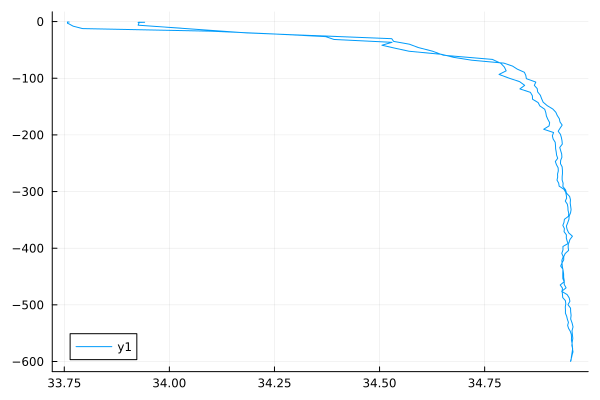

In [99]:
plot(fl_initial_profile.salinity, -fl_initial_profile.pressure)

In [100]:
# function to calculate density and add to initial profile 
function get_density(initial_profile)
    sa = gsw_sa_from_sp.(initial_profile.salinity, initial_profile.pressure, initial_profile.longitude, initial_profile.latitude) # calculate absolute salinity
    ct = gsw_ct_from_t.(sa, initial_profile.temperature, initial_profile.pressure) # calculate conservative temperature 
    density = gsw_rho.(sa, ct, initial_profile.pressure)

    return density 
end 

fl_ρ_0 = get_density(fl_initial_profile) 

# do same for electa 

227-element Vector{Float64}:
 1027.2221968281253
 1027.2167076929359
 1027.216924429773
 1027.2175666845333
 1027.218060601689
 1027.2116699742685
 1027.2185947212322
 1027.2139508652208
 1027.2140797026257
 1027.2123888819774
    ⋮
 1027.672044325443
 1027.5420203524714
 1027.4067746078028
 1027.180140231383
 1027.1435337290397
 1027.114531926384
 1027.1098047514256
 1027.0973659760202
 1027.1015395050767

In [101]:
z = fl_initial_profile.pressure
z_fine = collect(0:1:600)

# sort z and ρ
z_sorted, sort_idx = sort(z), sortperm(z)
ρ_sorted = fl_ρ_0[sort_idx]

# interpolate density onto finer depth grid 
itp = LinearInterpolation(z_sorted, ρ_sorted, extrapolation_bc=Flat())
fl_ρ_interp = itp.(z_fine)

601-element Vector{Float64}:
 1027.0973659760202
 1027.1633894303113
 1027.2154752617287
 1027.1321858091815
 1027.124735576807
 1027.1715842931665
 1027.2184330095256
 1027.201515009105
 1027.1489766980635
 1027.1512315024986
    ⋮
 1030.8664483782854
 1030.870923738711
 1030.87566633177
 1030.8805707747797
 1030.885475217789
 1030.8903796607985
 1030.8948154989644
 1030.8991317040034
 1030.9030914707705

In [102]:
# interpolate temperature onto finer depth grid 
T_sorted = fl_initial_profile.temperature[sort_idx]

itp = LinearInterpolation(z_sorted, T_sorted, extrapolation_bc=Flat())
fl_T_interp = itp.(z_fine)

601-element Vector{Float64}:
 0.2333
 0.4734640602920396
 0.6680780103976394
 0.3214021655349606
 0.2660888129803587
 0.4336223895660275
 0.6011559661516964
 0.5036675681870273
 0.258136969974788
 0.23894544430890496
 ⋮
 0.1418854771784232
 0.14603485477178418
 0.14437758220502908
 0.13920350096711803
 0.13402941972920696
 0.12885533849129588
 0.12416026571282579
 0.12225008488964345
 0.1225

In [103]:
# interpolate salinity onto finer depth grid 
S_sorted = fl_initial_profile.salinity[sort_idx]

itp = LinearInterpolation(z_sorted, S_sorted, extrapolation_bc=Flat())
fl_S_interp = itp.(z_fine)

601-element Vector{Float64}:
 33.7575
 33.85492063118229
 33.927451440213574
 33.79355975408332
 33.77446652433817
 33.838591980436306
 33.90271743653443
 33.86886332798533
 33.780277492550994
 33.77576831190766
  ⋮
 34.95646393993282
 34.95656273463742
 34.956464477756285
 34.9562468762089
 34.95602927466151
 34.95581167311412
 34.95505325498212
 34.9544
 34.9544

In [207]:
# calcualte temperature profile 

# start_time_index = 350 # in fl_df, should be start of a new profile, ex profile number 150 
# end_time_index = 400

# profile_num = 101 # should already exist 
# initial_profile = get_temp_profile(fl_df, profile_num)
# T_0 = initial_profile.temperature

# fl_df_subset # should already exist 
# fl_mld_subset # should already match dimensions of subset from interpolation 

using Statistics
dt = mean(diff(datetime2unix.(fl_df_subset.time)))
dh = diff(fl_mld_interp)

# fl_delta_t # should already match dimensions of subset from interpolation 

# fl_F_0 # should already match dimensions of subset from interpolation 

# fl_ρ_0
c = 3991.0

# Find the thickness of each layer delta_z
z = z_fine 
dz = 0.5
# dz = similar(z) # initialize array 
# dz[2:end-1] .= 0.5 .* (delta_z[1:end-1] .+ delta_z[2:end])  # central avg
# dz[1] = delta_z[1]               # forward diff at top
# dz[end] = delta_z[end]           # backward diff at bottom

Nt = length(fl_df_subset.time)
Nz = length(z)

T = Array{Float64}(undef, Nz, Nt) # initialize temp time vs. depth array
T[:, 1] .= fl_T_interp  # Initial condition at T_0

# sort glider lat/long arrays to get proper F_0 value 
sort_long = sort(surface_fl_data.longitude)
sort_lat = sort(surface_fl_data.latitude)

# find glider lat/long index at start of profile in the sorted (interpolated F_0 array)
flux_profile_num = 186 # 150
long_idx = findfirst(==(surface_fl_data.longitude[2*flux_profile_num-1]), sort_long)
lat_idx = findfirst(==(surface_fl_data.latitude[2*flux_profile_num-1]), sort_lat)

# Q_conv_list = [1.0]
# heat_cap_list = [1.0]
q_entrain_list = [1.0]

for i = 2:Nt
    h = fl_mld_interp[i]

    # Get indices of depths within mixed layer
    ml_idx = findall(z .<= h)
    mld_idx = findlast(z .<= h)

    # Subset variables within the MLD
    ρ_mld = fl_ρ_interp[ml_idx] 
    # dz_mld = dz[ml_idx]

    # Compute mixed layer heat capacity: ∑ ρ(z) * Δz * c
    heat_capacity = sum(ρ_mld .* dz) * c
    # append!(heat_cap_list, heat_capacity)

    # Compute surface heating and entrainment
    Q_conv = (fl_F_0[long_idx, lat_idx, i]) * dt
    # Q_conv = (v[i]) * dt
    # append!(Q_conv_list, Q_conv)
    
    # dh_pos = max(dh[i-1], 0.0) # only positive dh values (deepening of mixed layer) allow for entrainment 
    Q_entrain = fl_ρ_0[mld_idx] * c * fl_delta_t[i] * dh[i-1]
    append!(q_entrain_list, Q_entrain)

    # Total temperature change in mixed layer
    temp_change = (Q_conv + Q_entrain) / heat_capacity

    # Update T(z, t)
    for j in 1:Nz
        if z[j] <= h
            T[j, i] = T[j, i-1] + temp_change
        else
            T[j, i] = T[j, i-1]
            # T[j, i] = T[ml_idx[end], i-1] + temp_change  # no change below MLD
        end
    end 
end 

T 

601×2894 Matrix{Float64}:
 0.2333    0.233404  0.233415  …  -0.311948   -0.33113    -0.332948
 0.473464  0.473568  0.47358      -0.0717842  -0.0909663  -0.0927838
 0.668078  0.668182  0.668193      0.279063    0.259881    0.258064
 0.321402  0.321506  0.321518     -0.0762293  -0.0762293  -0.0762293
 0.266089  0.266193  0.266204     -0.0417703  -0.0417703  -0.0417703
 0.433622  0.433726  0.433738  …   0.185535    0.185535    0.185535
 0.601156  0.60126   0.601271      0.461888    0.461888    0.461888
 0.503668  0.503772  0.503783      0.425587    0.425587    0.425587
 0.258137  0.258241  0.258252      0.175138    0.175138    0.175138
 0.238945  0.239049  0.239061      0.204315    0.204315    0.204315
 ⋮                             ⋱                          
 0.141885  0.141885  0.141885      0.141885    0.141885    0.141885
 0.146035  0.146035  0.146035      0.146035    0.146035    0.146035
 0.144378  0.144378  0.144378      0.144378    0.144378    0.144378
 0.139204  0.139204  0.13920

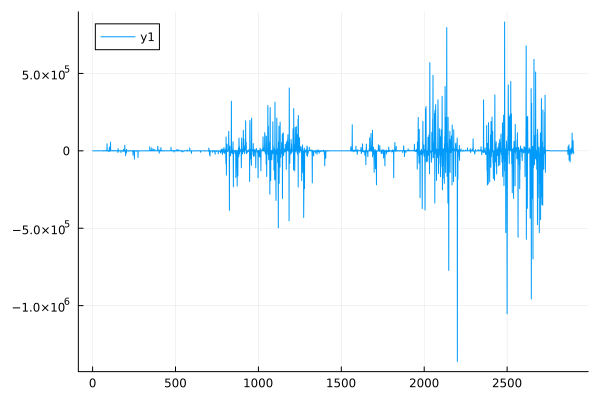

In [115]:
plot(q_entrain_list)

In [214]:
# plot temperature 

using PyCall

# Import Python libraries
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")

t_hours = (datetime2unix.(fl_df_subset.time) .- datetime2unix(fl_df_subset.time[1])) ./ 3600  # in hours

# Convert Julia arrays to NumPy arrays
T_py = np.array(T)
z_py = np.array(z)
t_py = np.array(t_hours)

# Create figure
fig, ax = plt.subplots()

# Plot heatmap
c = ax.pcolormesh(t_py, z_py, T_py; shading="auto", cmap="coolwarm", vmin=0, vmax=3.5)
plt.ylim(0, 10)

# Flip y-axis to have surface at top
ax.invert_yaxis()

# Add labels and title
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Depth [m]")
ax.set_title("FL Temperature Profile 11/21") # 11/21

# Add colorbar
fig.colorbar(c, ax=ax, label="Temperature (°C)")

# Show plot
plt.savefig("/Users/natenowel/Desktop/Plots/fl/low_flux_profiles/temp/tplot_10m_v2.png")
# plt.savefig("/Users/natenowel/Desktop/temp.png")


In [208]:
# calculate salnity profile 

# start_time_index = 350 # in fl_df, should be start of a new profile, ex profile number 150 
# end_time_index = 400

# fl_S_0 = initial_profile.salinity # should already exist 

# fl_df_subset # should already exist 
# fl_mld_subset # should already match dimensions of subset from interpolation 

# need to calculate delta_t and heat capacity at each time step, need initial density profile same size as inital_profile.pressure 
dt = mean(diff(datetime2unix.(fl_df_subset.time)))
dh = diff(fl_mld_interp)

# fl_delta_s # should already match dimensions of subset from interpolation 
# delta_s_subset = fl_delta_s[start_time_index:end_time_index]

# fl_E_0 # should already match dimensions of subset from interpolation 
# fl_P_0
# E_0_subset = fl_E_0[start_time_index:end_time_index]

z = z_fine

Nt = length(fl_df_subset.time)
Nz = length(z)

S = Array{Float64}(undef, Nz, Nt) # initialize temp time vs. depth array
S[:, 1] .= fl_S_interp  # Initial condition at t0

# sort glider lat/long arrays to get proper F_0 value 
sort_long = sort(surface_fl_data.longitude)
sort_lat = sort(surface_fl_data.latitude)

# find glider lat/long index at start of profile in the sorted (interpolated F_0 array)
flux_profile_num = 186 # 150
long_idx = findfirst(==(surface_fl_data.longitude[2*flux_profile_num-1]), sort_long)
lat_idx = findfirst(==(surface_fl_data.latitude[2*flux_profile_num-1]), sort_lat)

surf_salinity = fl_S_interp[1]

for i = 2:Nt
    h = fl_mld_interp[i]
    # dh = fl_mld_subset[i] - fl_mld_subset[i-1]

    # Compute surface heating and entrainment
    # S_conv = ((fl_E_0[long_idx, lat_idx, i]) / h) * dt
    S_conv = (surf_salinity * (fl_E_0[long_idx, lat_idx, i]-fl_P_0[long_idx, lat_idx, i]) / (3600*h)) * dt
    S_entrain = (fl_delta_s[i] / h) * dh[i-1]

    # Total temperature change in mixed layer
    salinity_change = (S_conv + S_entrain) 

    # Update T(z, t)
    for j in 1:Nz
        if z[j] <= h
            S[j, i] = S[j, i-1] + salinity_change
        else
            S[j, i] = S[j, i-1] # no change below MLD
        end
    end 
end 

S

601×2894 Matrix{Float64}:
 33.7575  33.7575  33.7575  33.7575  …  33.6262  33.6261  33.6242  33.6242
 33.8549  33.8549  33.8549  33.8549     33.7236  33.7235  33.7216  33.7216
 33.9275  33.9275  33.9275  33.9275     33.8973  33.8972  33.8954  33.8953
 33.7936  33.7936  33.7936  33.7936     33.7624  33.7624  33.7624  33.7624
 33.7745  33.7745  33.7745  33.7745     33.7518  33.7518  33.7518  33.7518
 33.8386  33.8386  33.8386  33.8386  …  33.8241  33.8241  33.8241  33.8241
 33.9027  33.9027  33.9027  33.9027     33.9064  33.9064  33.9064  33.9064
 33.8689  33.8689  33.8689  33.8689     33.8814  33.8814  33.8814  33.8814
 33.7803  33.7803  33.7803  33.7803     33.7957  33.7957  33.7957  33.7957
 33.7758  33.7758  33.7758  33.7758     33.8007  33.8007  33.8007  33.8007
  ⋮                                  ⋱   ⋮                         
 34.9565  34.9565  34.9565  34.9565     34.9565  34.9565  34.9565  34.9565
 34.9566  34.9566  34.9566  34.9566     34.9566  34.9566  34.9566  34.9566
 34.95

In [218]:
# Plot salinity
using PyCall

# Import Python libraries
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")

t_hours = (datetime2unix.(fl_df_subset.time) .- datetime2unix(fl_df_subset.time[1])) ./ 3600  # in hours

# Convert Julia arrays to NumPy arrays
S_py = np.array(S)
z_py = np.array(z)
t_py = np.array(t_hours)

# Create figure
fig, ax = plt.subplots()

# Plot heatmap
c = ax.pcolormesh(t_py, z_py, S_py; shading="auto", cmap="viridis", vmin=33, vmax=35)
plt.ylim(0, 10)

# Flip y-axis to have surface at top
ax.invert_yaxis()

# Add labels and title
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Depth [m]")
ax.set_title("FL Salinity Profile 11/21") # 11/21

# Add colorbar
fig.colorbar(c, ax=ax, label="Salinity")

# Show plot
plt.savefig("/Users/natenowel/Desktop/Plots/fl/low_flux_profiles/salinity/splot1_10m_v2.png")

In [ ]:
# Plot ERA5 variable using cartopy 

# Import matplotlib and cartopy
mpl = pyimport("matplotlib.pyplot")
cartopy_crs = pyimport("cartopy.crs")

# data
lons = sort(surface_fl_data.longitude)
lats = sort(surface_fl_data.latitude)
data = fl_interp_tot_hf[:, :, 1]  # initial heat flux for profile 

# Set up a map projection with Cartopy
fig = mpl.figure()
ax = fig.add_subplot(111, projection = cartopy_crs.PlateCarree())  

# Plot data as filled contours
contour = ax.contourf(lons, lats, data;
    transform = cartopy_crs.PlateCarree(), cmap = "coolwarm")

ax.set_extent([minimum(lons), maximum(lons), minimum(lats), maximum(lats)],
              crs=cartopy_crs.PlateCarree())


# add dot showing glider location 
# Get glider location
glider_lon = surface_fl_data.longitude[profile_num*2 - 1]
glider_lat = surface_fl_data.latitude[profile_num*2 - 1]

# Plot the glider location
ax.scatter([glider_lon], [glider_lat],
           color="green", s=50, marker="o",
           transform=cartopy_crs.PlateCarree(), zorder=10)


# Optionally add a label or legend
ax.text(glider_lon - 0.05, glider_lat + 0.05, "Glider", transform = cartopy_crs.PlateCarree(), fontsize = 6)
ax.legend(loc = "lower right", fontsize = 6)

# Add colorbar with label (with shrink to make it thinner)
cbar = mpl.colorbar(contour, ax = ax, shrink = 0.5, pad=0.05)
# cbar.ax.set_title("Total Heat Flux", fontsize = 8)
cbar.ax.tick_params(labelsize = 6)

# Display only bottom and left gridlabels
gl = ax.gridlines(draw_labels = true)
gl.top_labels = false
gl.right_labels = false

# Add coastlines and title 
ax.coastlines()
# ax.gridlines(draw_labels = false)
ax.set_title("Total Heat Flux Distribution in Jan Mayen Region", fontsize = 10)

# Change background color
# fig.patch.set_facecolor("lightblue")  

fig.tight_layout()
# fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

# Save the plot
mpl.savefig("/Users/natenowel/Desktop/fig.png")
mpl.close()

In [62]:
mpl = pyimport("matplotlib.pyplot")
cartopy_crs = pyimport("cartopy.crs")

start_idx = 500
idx = start_idx-1
stop_idx = 550
i=0
first_profile = 145 -1 # so last profile should be 195

for t = start_idx:stop_idx
    i+=1
    idx+=1
    first_profile+=1

    # data
    lons = sort(surface_fl_data.longitude)
    lats = sort(surface_fl_data.latitude)
    data = fl_interp_tot_hf[:, :, t]  # initial heat flux for profile 

    # Set up a map projection with Cartopy
    fig = mpl.figure()
    ax = fig.add_subplot(111, projection = cartopy_crs.PlateCarree())  

    # Plot data as filled contours
    contour = ax.contourf(lons, lats, data;
        transform = cartopy_crs.PlateCarree(), 
        cmap = "coolwarm", 
        vmin = -700, vmax = 0
        )

    ax.set_extent([minimum(lons), maximum(lons), minimum(lats), maximum(lats)],
                crs=cartopy_crs.PlateCarree())


    # add dot showing glider location 
    # Get glider location
    glider_lon = surface_fl_data.longitude[first_profile*2 - 1]
    glider_lat = surface_fl_data.latitude[first_profile*2 - 1]
    time = surface_fl_data.time[first_profile*2 - 1]

    # Plot the glider location
    ax.scatter([glider_lon], [glider_lat],
            color="green", s=50, marker="o",
            transform=cartopy_crs.PlateCarree(), zorder=10)


    # Optionally add a label or legend
    ax.text(glider_lon + 0.1, glider_lat - 0.1, "Glider", transform = cartopy_crs.PlateCarree(), fontsize = 6)
    # ax.legend(loc = "lower right", fontsize = 6)

    # Add colorbar with label (with shrink to make it thinner)
    cbar = mpl.colorbar(contour, ax = ax, shrink = 0.5, pad=0.05)
    cbar.ax.set_title("Total Heat Flux (W/m^2)", fontsize = 8)
    cbar.ax.tick_params(labelsize = 6)

    # Display only bottom and left gridlabels
    gl = ax.gridlines(draw_labels = true)
    gl.top_labels = false
    gl.right_labels = false

    # Add coastlines and title 
    ax.coastlines()
    # ax.gridlines(draw_labels = false)
    ax.set_title("Total Heat Flux, 11/23", fontsize = 10)
    # ax.set_title("Total Heat Flux, $time, Profile $first_profile, index $idx", fontsize = 10)

    # Change background color
    # fig.patch.set_facecolor("lightblue")  

    fig.tight_layout()
    # fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

    # Save the plot
    mpl.savefig("/Users/natenowel/Desktop/Plots/fl/hf/plot$i.png")
    mpl.close()
    
end 
    

In [134]:
latitude_low_flux = surface_fl_data.latitude[2*150 - 1];
longitude_low_flux = surface_fl_data.longitude[2*150 - 1];

z = z_fine
t = fl_df_low_flux.time

long_arr_lf = fill(longitude_low_flux, length(z))
lat_arr_lf = fill(latitude_low_flux, length(z))

# initialize new dataframe 
lf_df = DataFrame(time = DateTime[], 
                  temperature = Float64[], 
                  salinity = Float64[], 
                  latitude = Float64[],
                  pressure = Float64[], 
                  longitude = Float64[], 
                  profile_number = Int64[], 
                  absolute_salinity = Float64[],
                  conservative_temperature = Float64[]
                  )

profile_num = 0
for i = 1:length(t)
    profile_num+=1
    append!(lf_df.time, fill(t[i], length(z)));
    append!(lf_df.temperature, fl_T_low_flux[:, i]);
    append!(lf_df.salinity, fl_S_low_flux[:, i]);
    append!(lf_df.latitude, lat_arr_lf);
    append!(lf_df.pressure, z);
    append!(lf_df.longitude, long_arr_lf);
    append!(lf_df.profile_number, fill(profile_num, length(z)));

    sa = gsw_sa_from_sp.(fl_S_low_flux[:, i], z, long_arr_lf, lat_arr_lf)
    ct = gsw_ct_from_t.(sa, fl_T_low_flux[:, i], z)
    append!(lf_df.absolute_salinity, sa);
    append!(lf_df.conservative_temperature, ct);
end 

In [135]:
lf_df

Row,time,temperature,salinity,latitude,pressure,longitude,profile_number,absolute_salinity,conservative_temperature
,DateTime,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,2023-11-21T06:29:31.288,0.2333,33.7575,71.3523,0.0,-8.52747,1,33.9179,0.238706
2,2023-11-21T06:29:31.288,0.473464,33.8549,71.3523,1.0,-8.52747,1,34.0158,0.478481
3,2023-11-21T06:29:31.288,0.668078,33.9275,71.3523,2.0,-8.52747,1,34.0887,0.67275
4,2023-11-21T06:29:31.288,0.321402,33.7936,71.3523,3.0,-8.52747,1,33.9542,0.326578
5,2023-11-21T06:29:31.288,0.266089,33.7745,71.3523,4.0,-8.52747,1,33.935,0.271293
6,2023-11-21T06:29:31.288,0.433622,33.8386,71.3523,5.0,-8.52747,1,33.9994,0.438556
7,2023-11-21T06:29:31.288,0.601156,33.9027,71.3523,6.0,-8.52747,1,34.0639,0.605783
8,2023-11-21T06:29:31.288,0.503668,33.8689,71.3523,7.0,-8.52747,1,34.0299,0.508401
9,2023-11-21T06:29:31.288,0.258137,33.7803,71.3523,8.0,-8.52747,1,33.9409,0.26317


In [137]:
latitude_high_flux = surface_fl_data.latitude[2*186 - 1];
longitude_high_flux = surface_fl_data.longitude[2*186 - 1];

z = z_fine
t = fl_df_high_flux.time

long_arr_hf = fill(longitude_high_flux, length(z))
lat_arr_hf = fill(latitude_high_flux, length(z))

# initialize new dataframe 
hf_df = DataFrame(time = DateTime[], 
                  temperature = Float64[], 
                  salinity = Float64[], 
                  latitude = Float64[],
                  pressure = Float64[], 
                  longitude = Float64[], 
                  profile_number = Int64[], 
                  absolute_salinity = Float64[],
                  conservative_temperature = Float64[]
                  )

profile_num = 0
for i = 1:length(t)
    profile_num+=1
    append!(hf_df.time, fill(t[i], length(z)));
    append!(hf_df.temperature, fl_T_high_flux[:, i]);
    append!(hf_df.salinity, fl_S_high_flux[:, i]);
    append!(hf_df.latitude, lat_arr_hf);
    append!(hf_df.pressure, z);
    append!(hf_df.longitude, long_arr_hf);
    append!(hf_df.profile_number, fill(profile_num, length(z)));

    sa = gsw_sa_from_sp.(fl_S_high_flux[:, i], z, long_arr_hf, lat_arr_hf)
    ct = gsw_ct_from_t.(sa, fl_T_high_flux[:, i], z)
    append!(hf_df.absolute_salinity, sa);
    append!(hf_df.conservative_temperature, ct);
end 

In [138]:
hf_df 

Row,time,temperature,salinity,latitude,pressure,longitude,profile_number,absolute_salinity,conservative_temperature
,DateTime,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,2023-11-23T00:00:07.622,0.0549,33.5489,71.355,0.0,-7.4972,1,33.7084,0.0610867
2,2023-11-23T00:00:07.622,0.0571756,33.5419,71.355,1.0,-7.4972,1,33.7014,0.0633601
3,2023-11-23T00:00:07.622,0.0144195,33.5651,71.355,2.0,-7.4972,1,33.7246,0.0204415
4,2023-11-23T00:00:07.622,0.0557051,33.5422,71.355,3.0,-7.4972,1,33.7016,0.0618212
5,2023-11-23T00:00:07.622,0.029643,33.552,71.355,4.0,-7.4972,1,33.7115,0.035665
6,2023-11-23T00:00:07.622,0.00358086,33.5617,71.355,5.0,-7.4972,1,33.7213,0.00950995
7,2023-11-23T00:00:07.622,0.0169866,33.5571,71.355,6.0,-7.4972,1,33.7166,0.0229121
8,2023-11-23T00:00:07.622,0.0409028,33.5486,71.355,7.0,-7.4972,1,33.7081,0.0468485
9,2023-11-23T00:00:07.622,0.061171,33.5414,71.355,8.0,-7.4972,1,33.7009,0.067129


In [156]:
lf_model_mld = find_mld(lf_df, 0.075, "profile_number", "conservative_temperature", "absolute_salinity", "pressure", "time")

Row,diveNum,density_mld,time
,Int64,Float64,DateTime
1,1,14.0,2023-11-21T06:29:31.288
2,2,14.0,2023-11-21T06:30:01.305
3,3,14.0,2023-11-21T06:31:00.245
4,4,14.0,2023-11-21T06:31:04
5,5,14.0,2023-11-21T06:31:30.189
6,6,14.0,2023-11-21T06:31:57.305
7,7,14.0,2023-11-21T06:32:27.332
8,8,14.0,2023-11-21T06:32:57.350
9,9,14.0,2023-11-21T06:33:27.348


In [161]:
t_hours = (datetime2unix.(fl_df_low_flux.time) .- datetime2unix(fl_df_low_flux.time[1])) ./ 3600  # in hours
p = plot(t_hours, -lf_model_mld.density_mld, title="Analytical Model Low Flux MLD", xlabel = "Time (hours)", ylabel = "Mixed Layer Depth (m)")
savefig(p, "/Users/NateNowel/Desktop/Plots/fl/MLD_plots/Analytical_LF_MLD.png")

"/Users/NateNowel/Desktop/Plots/fl/MLD_plots/Analytical_LF_MLD.png"

In [179]:
hf_model_mld = find_mld(hf_df, .13, "profile_number", "conservative_temperature", "absolute_salinity", "pressure", "time")

Row,diveNum,density_mld,time
,Int64,Float64,DateTime
1,1,36.0,2023-11-23T00:00:07.622
2,2,36.0,2023-11-23T00:00:37.639
3,3,36.0,2023-11-23T00:01:07.666
4,4,36.0,2023-11-23T00:01:37.684
5,5,36.0,2023-11-23T00:02:07.700
6,6,36.0,2023-11-23T00:02:37.720
7,7,36.0,2023-11-23T00:03:07.738
8,8,36.0,2023-11-23T00:03:37.755
9,9,36.0,2023-11-23T00:04:07.772


In [181]:
t_hours = (datetime2unix.(fl_df_high_flux.time) .- datetime2unix(fl_df_high_flux.time[1])) ./ 3600  # in hours
p = plot(t_hours, -hf_model_mld.density_mld, title="Analytical Model High Flux MLD", xlabel = "Time (hours)", ylabel = "Mixed Layer Depth (m)")
savefig(p, "/Users/NateNowel/Desktop/Plots/fl/MLD_plots/Analytical_HF_MLD.png")

"/Users/NateNowel/Desktop/Plots/fl/MLD_plots/Analytical_HF_MLD.png"

In [20]:
# Function for turning CTD dataframe into a struct, each of the fields in the struct is a matrix, shape of depths x dives
mutable struct CTD_JM
    temp::Matrix{Float64}  # Temperature matrix
    salt::Matrix{Float64}  # Salinity matrix
    time::Matrix{Float64}  # Time matrix
end
function CTD_struct(df::DataFrame)
    depth = df.pressure
    # Remove NaN values from depth and corresponding rows in df
    nan_ind = findall(isnan, depth)
    if !isempty(nan_ind)
        depth = depth[.!isnan.(depth)]
        df = df[.!isnan.(df.pressure), :]
    end
    # Creating a depth grid for the data
    min_depth = minimum(depth)
    max_depth = maximum(depth)
    x = LinRange(min_depth, max_depth, Int(round(max_depth)))
    # Grouping the data by profile number
    gdf = groupby(df, :profile_number)
    dives = unique(df.profile_number)
    # Creating the matrices for temperature, salinity, and time
    temp_mat = zeros(length(x), length(dives))
    salt_mat = zeros(length(x), length(dives))
    time_mat = zeros(length(x), length(dives))
    # Looping through each dive to interpolate the data onto the depth grid
    for i in 1:length(dives)
        dive = gdf[i]
        depth = dive.pressure
        salt = dive.salinity
        temp = dive.temperature
        time = dive.time
        date_float = Dates.datetime2unix.(time)
        # Sorting the data by depth
        sort_id = sortperm(depth)
        depth = depth[sort_id]
        temp = temp[sort_id]
        salt = salt[sort_id]
        date_float = date_float[sort_id]
        # Interpolating the data onto the depth grid
        spl_T = Spline1D(depth, temp)
        spl_S = Spline1D(depth, salt)
        spl_time = Spline1D(depth, date_float)
        Ti = spl_T.(x)
        Si = spl_S.(x)
        timei = spl_time.(x)
        temp_mat[:, i] = Ti
        salt_mat[:, i] = Si
        time_mat[:, i] = timei
    end
    return CTD_JM(temp_mat, salt_mat, time_mat)
end

CTD_struct (generic function with 1 method)

In [26]:
glider_hf_df = CTD_struct(fl_df_high_flux)

using PyCall, Dates

# Import matplotlib
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")

# --- Prepare time axis (in hours from start) ---
time_vector = glider_hf_df.time[1, :]
time_dt = Dates.unix2datetime.(time_vector)
time_hours = (time_dt .- time_dt[1]) ./ Hour(1)

# --- Clean temperature ---
temp_clean = copy(glider_hf_df.temp)
temp_clean[temp_clean .> 4] .= NaN
temp_clean[temp_clean .< -1] .= NaN

# --- Depth vector ---
depth = fl_df_high_flux.pressure
min_depth = minimum(depth)
max_depth = maximum(depth)
glider_hf_depth = LinRange(min_depth, max_depth, Int(round(max_depth)))

# --- Convert to NumPy arrays ---
depth_np = np.array(glider_hf_depth)
time_np = np.array(time_hours)
temp_np = np.array(temp_clean)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# Plot full matrix but show only top 100m with ylim
c = ax.pcolormesh(time_np, depth_np, temp_np; shading="auto", cmap="coolwarm")

# Flip y-axis so shallow is on top
ax.invert_yaxis()

# Apply y-limit for top 100m
ax.set_ylim(10, 0)

# Labels and title
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Depth (m)")
ax.set_title("FL Temperature Profile 11/23")

# Add colorbar
cb = fig.colorbar(c, ax=ax)
cb.set_label("Temperature (°C)")

# Save to file
fig.savefig("/Users/NateNowel/Desktop/Plots/fl/high_flux_profiles/tplot_hf_10m.png")

In [32]:
glider_hf_df = CTD_struct(fl_df_high_flux)

# Import matplotlib
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")

# --- Prepare time axis (in hours from start) ---
time_vector = glider_hf_df.time[1, :]
time_dt = Dates.unix2datetime.(time_vector)
time_hours = (time_dt .- time_dt[1]) ./ Hour(1)

# --- Clean salinity ---
salinity_clean = copy(glider_hf_df.salt)
salinity_clean[salinity_clean .> 35] .= NaN
salinity_clean[salinity_clean .< 33] .= NaN

# --- Depth vector ---
depth = fl_df_high_flux.pressure
min_depth = minimum(depth)
max_depth = maximum(depth)
glider_hf_depth = LinRange(min_depth, max_depth, Int(round(max_depth)))

# --- Convert to NumPy arrays ---
depth_np = np.array(glider_hf_depth)
time_np = np.array(time_hours)
salinity_np = np.array(salinity_clean)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# Plot full matrix but show only top 100m with ylim
c = ax.pcolormesh(time_np, depth_np, salinity_np; shading="auto", cmap="viridis")

# Flip y-axis so shallow is on top
ax.invert_yaxis()

# Apply y-limit for top 100m
ax.set_ylim(10, 0)

# Labels and title
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Depth (m)")
ax.set_title("FL Salinity Profile 11/23")

# Add colorbar
cb = fig.colorbar(c, ax=ax)
cb.set_label("Salinity (psu)")

# Save to file
fig.savefig("/Users/natenowel/Desktop/Plots/fl/high_flux_profiles/splot_hf_10m.png")

In [36]:
glider_lf_df = CTD_struct(fl_df_low_flux)

# Import matplotlib
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")

# --- Prepare time axis (in hours from start) ---
time_vector = glider_lf_df.time[1, :]
time_dt = Dates.unix2datetime.(time_vector)
time_hours = (time_dt .- time_dt[1]) ./ Hour(1)

# --- Clean temperature ---
temp_clean = copy(glider_lf_df.temp)
temp_clean[temp_clean .> 4] .= NaN
temp_clean[temp_clean .< -1] .= NaN

# --- Depth vector ---
depth = fl_df_low_flux.pressure
min_depth = minimum(depth)
max_depth = maximum(depth)
glider_lf_depth = LinRange(min_depth, max_depth, Int(round(max_depth)))

# --- Convert to NumPy arrays ---
depth_np = np.array(glider_lf_depth)
time_np = np.array(time_hours)
temp_np = np.array(temp_clean)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# Plot full matrix but show only top 100m with ylim
c = ax.pcolormesh(time_np, depth_np, temp_np; shading="auto", cmap="coolwarm")

# Flip y-axis so shallow is on top
ax.invert_yaxis()

# Apply y-limit for top 100m
ax.set_ylim(10, 0)

# Labels and title
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Depth (m)")
ax.set_title("FL Temperature Profile 11/21")

# Add colorbar
cb = fig.colorbar(c, ax=ax)
cb.set_label("Temperature (°C)")

# Save to file
fig.savefig("/Users/NateNowel/Desktop/Plots/fl/low_flux_profiles/tplot_lf_10m.png")

In [290]:
depth = fl_df_low_flux.pressure
min_depth = minimum(depth)
max_depth = maximum(depth)
glider_lf_depth = LinRange(min_depth, max_depth, Int(round(max_depth)))

time_vector = glider_lf_df.time[1, :]  # Row 1, all columns
# Convert Unix time (in seconds) to DateTime vector
time_dt = Dates.unix2datetime.(time_vector)
time_hours = (time_dt .- time_dt[1]) ./ Hour(1)

salinity_clean = copy(glider_lf_df.salt)
salinity_clean[salinity_clean .> 35] .= NaN
salinity_clean[salinity_clean .< 33] .= NaN

s_lf = heatmap(
       time_hours,
       glider_lf_depth,
       salinity_clean,
       xlabel = "Time (hours)",
       ylabel = "Depth (m)",
       title = "FL Salinity Profile 11/21",
       colorbar_title = "Salinity (psu)",
       yflip = true,  # depth increases downward
       color = :viridis,
       # ylim=(0, 100)
       )

savefig(s_lf, "/Users/NateNowel/Desktop/Plots/fl/low_flux_profiles/lf_glider_salt.png")

"/Users/NateNowel/Desktop/Plots/fl/low_flux_profiles/lf_glider_salt.png"

In [41]:
glider_lf_df = CTD_struct(fl_df_low_flux)

# Import matplotlib
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")

# --- Prepare time axis (in hours from start) ---
time_vector = glider_lf_df.time[1, :]
time_dt = Dates.unix2datetime.(time_vector)
time_hours = (time_dt .- time_dt[1]) ./ Hour(1)

# --- Clean salinity ---
salinity_clean = copy(glider_lf_df.salt)
salinity_clean[salinity_clean .> 35] .= NaN
salinity_clean[salinity_clean .< 33] .= NaN

# --- Depth vector ---
depth = fl_df_low_flux.pressure
min_depth = minimum(depth)
max_depth = maximum(depth)
glider_hf_depth = LinRange(min_depth, max_depth, Int(round(max_depth)))

# --- Convert to NumPy arrays ---
depth_np = np.array(glider_hf_depth)
time_np = np.array(time_hours)
salinity_np = np.array(salinity_clean)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# Plot full matrix but show only top 100m with ylim
c = ax.pcolormesh(time_np, depth_np, salinity_np; shading="auto", cmap="viridis")

# Flip y-axis so shallow is on top
ax.invert_yaxis()

# Apply y-limit for top 100m
ax.set_ylim(10, 0)

# Labels and title
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Depth (m)")
ax.set_title("FL Salinity Profile 11/21")

# Add colorbar
cb = fig.colorbar(c, ax=ax)
cb.set_label("Salinity (psu)")

# Save to file
fig.savefig("/Users/NateNowel/Desktop/Plots/fl/low_flux_profiles/splot_lf_10m.png")

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
